# Importing Required Libraries

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import tensorflow.keras.backend as K
import keras
%matplotlib inline
from matplotlib import pyplot as plt

# Important Parameters

In [2]:
random_state=42
input_shape=(256, 256, 3)
train_batch_size=32
val_batch_size=32
train_lr=0.001
finetune_lr=0.00001
train_epochs=7
tune_epochs=5
es_patience=4
k_fold=5

# Dataset Preparation

In [3]:
!wget -q https://github.com/hasibzunair/synthetic-covid-cxr-dataset/releases/download/v0.1/G_NC.zip
!wget -q https://github.com/hasibzunair/synthetic-covid-cxr-dataset/releases/download/v0.1/G_PC.zip

In [4]:
!unzip -q G_NC.zip
!unzip -q G_PC.zip

In [5]:
!rm G_NC.zip
!rm G_PC.zip

In [6]:
normal_cases = os.listdir('G1')
pneumonia_cases = os.listdir('G2')

In [7]:
normal_cases = ['G1/' + img for img in normal_cases]
pneumonia_cases = ['G2/' + img for img in pneumonia_cases]

In [8]:
normal_labels = [0]*len(normal_cases)
pneumonia_labels = [1]*len(pneumonia_cases)

In [9]:
dataset = np.concatenate([normal_cases, pneumonia_cases])
labels = np.concatenate([normal_labels, pneumonia_labels])

# Data Exploration

In [10]:
print("Number of Normal Cases: ", len(normal_cases))
print("Number of pneumonia Cases: ", len(pneumonia_cases))
print("Number of Total Cases: ", len(normal_cases)+len(pneumonia_cases))

Number of Normal Cases:  16537
Number of pneumonia Cases:  4758
Number of Total Cases:  21295


In [11]:
print("Percentage of Normal Cases: ", len(normal_cases)*100/(len(normal_cases)+len(pneumonia_cases)))
print("Number of pneumonia Cases: ", len(pneumonia_cases)*100/(len(normal_cases)+len(pneumonia_cases)))
print("Ration of pneumonia to Normal Cases: ", len(pneumonia_cases)/len(normal_cases))

Percentage of Normal Cases:  77.6567269312045
Number of pneumonia Cases:  22.34327306879549
Ration of pneumonia to Normal Cases:  0.287718449537401


In [12]:
np.random.seed(random_state)
rand_index = np.random.randint(0, len(normal_cases))
norm_rand_image = Image.open(normal_cases[rand_index])
norm_rand_image = np.array(norm_rand_image)

In [13]:
rand_index = np.random.randint(0, len(pneumonia_cases))
pne_rand_image = Image.open(pneumonia_cases[rand_index])
pne_rand_image = np.array(pne_rand_image)

In [14]:
print(norm_rand_image.shape, pne_rand_image.shape)

(256, 256, 3) (256, 256, 3)


In [15]:
print(norm_rand_image.max())
print(norm_rand_image.min())

255
0


In [16]:
print(pne_rand_image.max())
print(pne_rand_image.min())

230
0


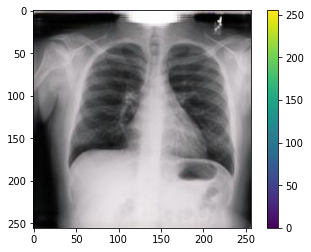

In [17]:
plt.imshow(norm_rand_image)
plt.colorbar()

# Transfer Learning

## Custom Generator

In [18]:
class DataGenerator(tf.keras.utils.Sequence):
    'Custom Generator to read data from disk for a given batch'
    def __init__(self, list_images, list_labels, batch_size=32, normalize=True,
                 augment=False, dim=(256,256), n_channels=3, shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = list_labels
        self.list_IDs = list_images
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.normalize = normalize
        self.augment = augment
        self.flip = tf.keras.layers.RandomFlip("horizontal")
        self.on_epoch_end()

    def load_image(self, index):
        'Reades the image as a numpy array given the name'
        infilename = self.list_IDs[index]
        img = Image.open(infilename)
        data = np.asarray(img)
        return data
    
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]  

        # Generate data
        X, y = self.__data_generation(indexes)

        # Normalize and Zero Center the data
        if self.normalize:
            X = (X / 255.0) - 0.5

        if self.augment:
            X = self.flip(X).numpy()

        return X, y

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.load_image(ID)

            # Store class
            y[i] = self.labels[ID]

        return X, y

## Utility Functions

In [19]:
def get_model(input_shape):
  'Returns the baseline model'
  model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape)
  return model

In [20]:
def freeze_model(model):
  'Returns the freezed model with added layers for initial training'
  inputs = tf.keras.Input(shape=model.input_shape[1:])
  x = model(inputs, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(1028)(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  # A Dense classifier with a single unit (binary classification)
  outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
  model = tf.keras.Model(inputs, outputs)
  return model

In [21]:
def unfreeze_model(model):
    'Returns the unfreezed model with added layers for initial training'
    for layer in model.layers:
        # We don't change the parameters of BatchNorm layers during fine-tuning
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

In [22]:
def get_class_weights(labels):
  class_labels = np.unique(labels)
  num_classes = len(class_labels)
  weights = [len(labels)/(num_classes*np.count_nonzero(labels==i)) for i in range(0, num_classes)]
  weights = np.array(weights) / (max(weights) - min(weights))
  return dict(enumerate(weights))

## Custom Metrics

In [23]:
def recall(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [24]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

In [31]:
def sparse_categorical_accuracy(y_true, y_pred):
    # flatten y_true in case it's in shape (num_samples, 1) instead of (num_samples,)
    return K.cast(K.equal(K.flatten(y_true),
                          K.cast(K.argmax(y_pred, axis=-1), K.floatx())),
                          K.floatx())

## Important Varriables

In [25]:
# Cross Validation Splitter
skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=random_state)

In [26]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=es_patience,
    verbose=1,
    mode="min")

mc = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.{epoch:02d}-{val_loss:.2f}.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

cb = [mc, es]

In [27]:
# Varriables for storing model history during train and finetune stages
finetune_history = []
train_history = []

# Varriables for storing validation history
fold_acc_history = []
fold_loss_history = []
fold_recall_history = []
fold_precision_history = []

In [ ]:
for i, (train_indexes, test_indexes) in enumerate(skf.split(dataset, labels)):
  print(f"******************* Fold-{i+1} Train *******************\n")
  
  # Splitting the train/val data for a given fold
  train_data, validation_data = dataset[train_indexes], dataset[test_indexes]
  train_labels, validation_labels = labels[train_indexes], labels[test_indexes]

  # Defining train/val Generator
  train_generator = DataGenerator(train_data, train_labels, train_batch_size,
                                  normalize=True, augment=True, dim=input_shape[:-1],
                                  n_channels=input_shape[-1])
  validation_generator = DataGenerator(validation_data, validation_labels, val_batch_size, normalize=True,
                                       dim=input_shape[:-1], n_channels=input_shape[-1])
  
  # Class Weight Calculation to handle data imbalance
  class_weights = get_class_weights(train_labels)

  print("Starting Initial Training..")
  # Initial Training
  model = get_model(input_shape) 
  model = freeze_model(model)
  model.compile(optimizer=tf.keras.optimizers.Adam(train_lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[sparse_categorical_accuracy, recall, precision])
  t_hist = model.fit(train_generator, validation_data=validation_generator, epochs=train_epochs,
            verbose=1, class_weight=class_weights, callbacks=cb)
  
  # Storing History
  train_history.append(t_hist)

  print("Starting Fine Tuning..")
  model = unfreeze_model(model)
  model.compile(optimizer=tf.keras.optimizers.Adam(finetune_lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[sparse_categorical_accuracy, recall, precision])
  f_hist = model.fit(train_generator, validation_data=validation_generator, epochs=tune_epochs,
            verbose=1, class_weight=class_weights, callbacks=cb)
  
  # Storing History
  finetune_history.append(f_hist)
  fold_acc_history.append(f_hist.history['val_acc'])
  fold_loss_history.append(f_hist.history['val_loss'])
  fold_recall_history.append(f_hist.history['val_recall'])
  fold_precision_history.append(f_hist.history['val_recall'])



******************* Fold-0 Train *******************

Starting Initial Training..
Epoch 1/7
408/532 [======================>.......] - ETA: 1:40 - loss: 0.7278 - sparse_categorical_accuracy: 0.3909 - recall: 0.2255 - precision: 0.2245

In [ ]:
# K-Fold Cross Validation Results 
print("Validation Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(fold_acc_history), np.std(fold_acc_history)))
print("Validation Loss: %.2f%% (+/- %.2f%%)" % (np.mean(fold_loss_history), np.std(fold_loss_history)))

In [ ]:
for i in range(0, len(k_fold)):
    train_acc = np.append(train_history[i].history['acc'], finetune_history[i].history['acc'])
    val_acc = np.append(train_history[i].history['val_acc'], finetune_history[i].history['val_acc'])
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title(f'Model Accuracy for Fold {i+1}')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.xticks(np.arange(1, len(train_acc)+1))
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    train_acc = np.append(train_history[i].history['loss'], finetune_history[i].history['loss'])
    val_acc = np.append(train_history[i].history['val_loss'], finetune_history[i].history['val_loss'])
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title(f'Model Loss for Fold {i+1}')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.xticks(np.arange(1, len(train_acc)+1))
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()